# Milestone 2

Nama: Dwi Putra Satria Utama

Batch 20

Dataset: ChatGPT sentiment analysis (https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis)

Objective:

Membangun model Sentiment Analysis untuk mengklasifikasikan chatgpt sentimen tweet menjadi positif, netral, atau negatif berdasarkan isi teks/tweet yang diunggah.

Problem Statement:

Dalam proyek ini, tujuan utama adalah untuk mengembangkan sebuah sistem Sentiment Analysis yang dapat mengenali dan mengklasifikasikan sentimen dari teks yang diunggah menjadi tiga kategori: positif, netral, atau negatif. Model yang akan dibangun akan memproses teks yang diberikan dan memberikan hasil prediksi tentang sentimen teks tersebut.

Matriks yang digunakan: Akurasi

# 2 - Import library

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


#pre-processing/feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
import ast
from nltk.stem import PorterStemmer
from collections import Counter

#modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#saving
import joblib


# 3 - Data loading

In [2]:
df = pd.read_csv('ChatGPT-sentiment-analysis.csv')

# menampilkan 10 baris pertama
df.head(10)

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
5,5,"Just launched ChatGPT, our new AI system which...",good
6,6,"As of 2 minutes ago, @OpenAI released their ne...",bad
7,7,ChatGPT coming out strong refusing to help me ...,good
8,8,#0penAl just deployed a thing I've been helpin...,good
9,9,Research preview of our newest model: ChatGPT\...,neutral


In [3]:
# menampilkan 10 baris terakhir
df.tail(10)

,Unnamed: 0,tweets,labels
219284,219284,Indie Media Today -- 12/31: ChatGPT AI Bias in...,bad
219285,219285,Podcast returns in 2023! 🐈🌙\n.\n#ai #chatgpt #...,bad
219286,219286,There's now an open source alternative to Chat...,good
219287,219287,One of my new favorite thing to do with #ChatG...,good
219288,219288,Sounds like AI can't predict 2023 trends 😆\n#n...,neutral
219289,219289,Other Software Projects Are Now Trying to Repl...,bad
219290,219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,219291,chatgpt is being disassembled until it can onl...,bad
219292,219292,2023 predictions by #chatGPT. Nothing really s...,bad
219293,219293,"From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0",neutral


In [4]:
# drop kolom unnamed
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.head(5)

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [6]:
# copy data
df_copy=df.copy()

# 4 - EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  219294 non-null  object
 1   labels  219294 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


Data terdiri dari 219294 baris dan 2 kolom dan tidak terdapat missing values


In [8]:
# menghitung data yang terduplikasi
duplicate = df.duplicated().sum()
duplicate

1671

Terdapat data yang terduplikasi dan selanjutnya akan dihandling



In [9]:
# handling data duplikat
df = df.drop_duplicates()
df.shape

(217623, 2)

Jumlah: labels
bad        106695
good        55754
neutral     55174
Name: count, dtype: int64


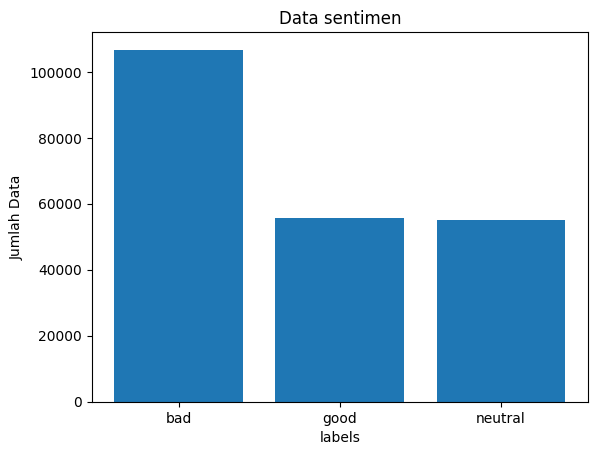

In [10]:
# cek data target

# Hitung jumlah data
sentimen_count = df['labels'].value_counts()
print('Jumlah:', sentimen_count)

# Visualisasi perbandingan jumlah data
plt.bar(sentimen_count.index, sentimen_count.values)
plt.xlabel('labels')
plt.ylabel('Jumlah Data')


# Atur judul dan sumbu y
plt.title('Data sentimen')
plt.ylabel('Jumlah Data')

plt.show()

Data imbalance dimana class bad lebih banyak dari pada yang lainnya

In [11]:
df = df.sort_values(by='labels')

# 4000 teratas sentiment category
bad_top_4000 = df[df["labels"] == "bad"].head(4000)
neutral_top_4000 = df[df["labels"] == "neutral"].head(4000)
good_top_4000 = df[df["labels"] == "good"].head(4000)

# concatenate
df = pd.concat([bad_top_4000, neutral_top_4000, good_top_4000])

# reset  index 
df = df.reset_index(drop=True)

# hitung jumlah data
sentimen = df['labels'].value_counts()
print('Jumlah:', sentimen)

Jumlah: labels
bad        4000
neutral    4000
good       4000
Name: count, dtype: int64


In [12]:
print(df[df['labels'] == 'neutral'])

                                                 tweets   labels
4000  Generative #AI is here: How tools like #ChatGP...  neutral
4001  #ChatGPT #ArtificialIntelligence \nWhy Everyon...  neutral
4002        Tried ChatGPT... Are you f#ing kidding me 🤯  neutral
4003  🤖👽\n6 exciting ways to use ChatGPT – from codi...  neutral
4004  We asked AI model ChatGPT to create us a Chris...  neutral
...                                                 ...      ...
7995  /1 ChatGPT will revolutionize the way we inter...  neutral
7996  Dionne Warwick could've saved a bunch of time ...  neutral
7997  Google's management has reportedly issued a 'c...  neutral
7998   I no longer like ChatGPT https://t.co/0DSD6UXRMP  neutral
7999  Just discovered I'm on my way to being a DevOp...  neutral

[4000 rows x 2 columns]


Handling dilakukan dengan undersampling karena menurut saya data yang digunakan cukup banyak dan digunakan hanya 4000 data agar tidak terlalu lama dalam proses dikarenakan keterbatasan device.

## WordCloud

In [13]:
# Mengambil kolom Review untuk melihat frekuensi kata
text = df['tweets'].tolist() 

# Menggabungkan list dan lowercase pada semua kata
text = ' '.join(text).lower()

# Mendefinisikan WordCloud
wordcloud = WordCloud(width = 1600, height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(text)

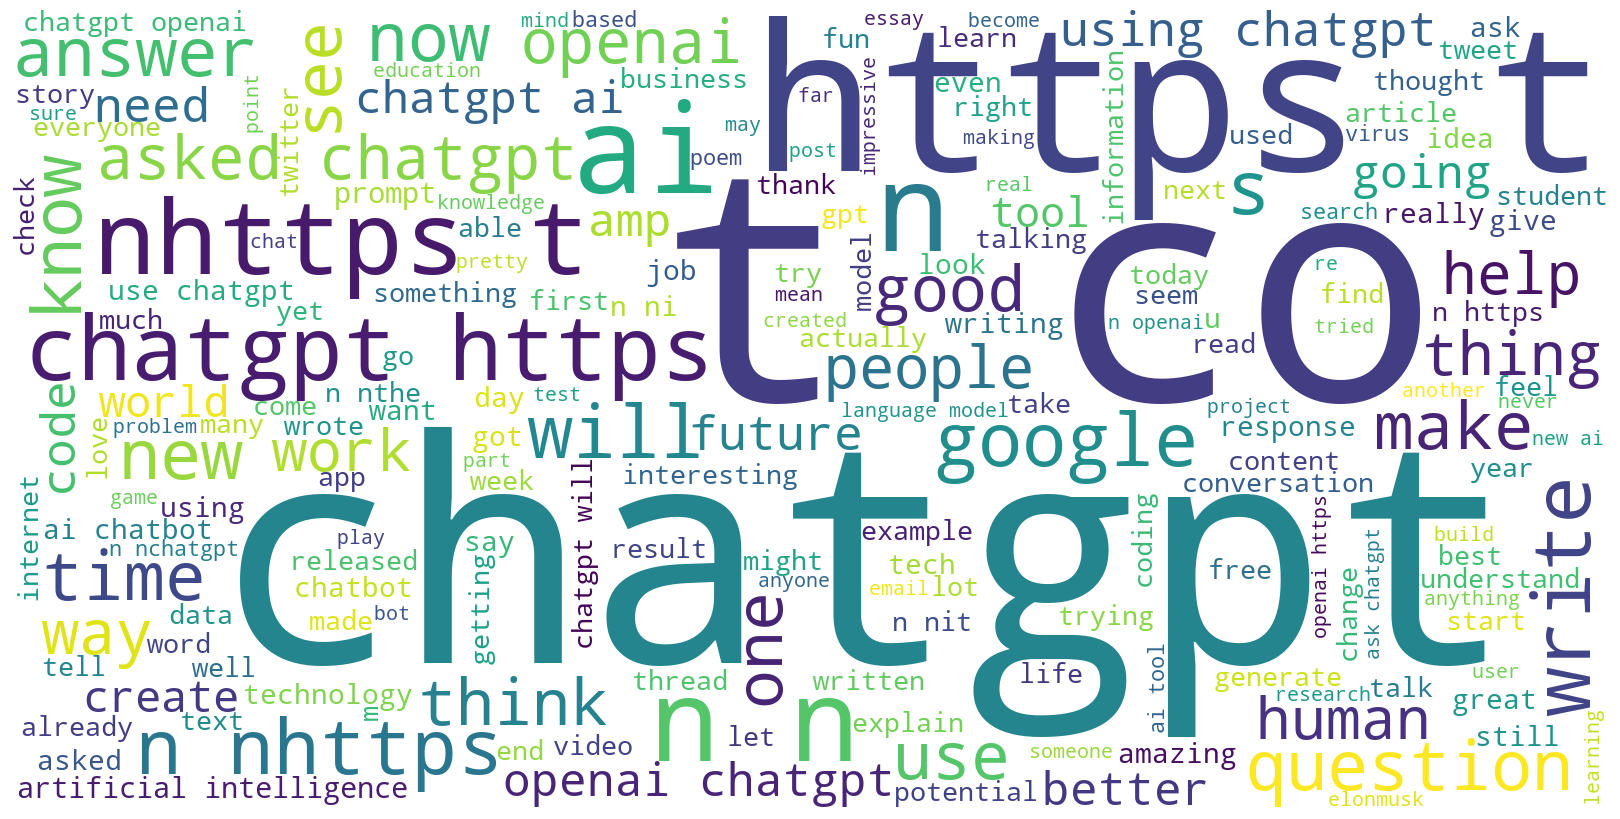

In [14]:
# Plot gambar WordCloud

plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Dalam visualisasi WordCloud (sebelum text prepocessing) di atas, kata-kata yang sering muncul dalam tweets ditampilkan dengan ukuran teks yang lebih besar untuk kata-kata yang memiliki frekuensi kemunculan yang lebih tinggi. Semakin sering sebuah kata muncul dalam tweet, semakin besar ukuran kata tersebut dalam gambar.

Pada gambar tersebut, kata "https" dan "chatgpt" menunjukkan ukuran teks yang paling besar, menandakan bahwa kata-kata ini sangat sering muncul dalam tweets. Namun, kata-kata lainnya mungkin tidak terlihat begitu representatif jika hanya dinilai dari besar atau kecilnya ukuran teks. Hal ini disebabkan karena tidak ada batasan yang jelas mengenai ukuran kata dalam visualisasi WordCloud.

# 5 - Text prepocessing

Alasan yang saya lakukan dalam proses ini berdasarkan data yang sudah saya pahami dan dari proses EDA:

- Load the dictionary slang/abbreviations menjadi kalimat standar (baku):

    Pada bagian ini, saya load file "chatwords.txt" yang berisi daftar slang atau singkatan beserta makna standarnya yang sudah saya buat sendiri. Contoh format btw dirubah menjadi by the way. 

- Additional Stopwords:

    Dalam analisis teks, kata-kata umum yang sering muncul dan memberikan sedikit informasi. Pada bagian ini, saya menambahkan beberapa kata ke dalam kamus stop_words, termasuk 'chatgpt', 'ai', 'openai', 'ha', 'wa'. Kata-kata ini akan dianggap stopwords dan dihilangkan dari teks selama preprocessing.

- Mengubah Teks ke Lowercase:

    Mengubah seluruh teks tweet ke huruf kecil agar tidak ada perbedaan dalam pemrosesan nanti karena perbedaan kapitalisasi.

- Menghilangkan Mention:

    Menghapus tanda @ dalam teks tweet karena informasi dari mention tersebut tidak relevan dalam analisis sentimen pada konteks kali ini.

- Menghilangkan Hashtag:

    Menghapus hashtag (#) dalam teks tweet karena informasi dari hashtag tidak diperlukan dalam analisis sentimen pada konteks kali ini.

- Menghilangkan \n:

    Menghapus karakter newline (newline character) untuk memastikan semua teks tweet berada dalam satu baris dan tidak mempengaruhi pemrosesan teks.

- Menghilangkan Whitespace:

    Menghapus whitespace (spasi) di awal dan akhir teks untuk membersihkan teks dari karakter yang tidak diperlukan.

- Menghilangkan Link:

    Menghapus link (URL) dari teks tweet karena link tidak relevan dalam analisis sentimen dan dapat mengganggu pemrosesan teks.

- Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika, dll.:

    Menghapus karakter non-alfabet seperti emoji, simbol matematika, dll., karena informasi dari karakter-karakter tersebut biasanya tidak relevan dalam analisis sentimen.

- Menghilangkan RT:

    Menghapus kata "RT" yang merupakan singkatan dari "Retweet" karena kata tersebut umumnya tidak memberikan informasi sentimen yang berguna.

- Melakukan Tokenisasi:

    Membagi teks tweet menjadi kata-kata individu (token) menggunakan library nltk dan metode word_tokenize.
    Memecah teks menjadi token (kata-kata) menggunakan word_tokenize dan menyimpan kata-kata yang hanya berisi huruf dan tanda -:

    Memastikan bahwa kata-kata hanya berisi huruf dan tanda "-" (misalnya kata seperti "non-government" tidak dipecah menjadi "non" dan "government").

- Melakukan lemmatisasi pada setiap kata untuk mengubahnya ke bentuk kata dasar:

    Lemmatisasi digunakan untuk mengubah kata-kata menjadi bentuk dasarnya. Misalnya, "running" menjadi "run" dan "cats" menjadi "cat". Hal ini membantu mengurangi variasi kata yang memiliki arti serupa. WordNetLemmatizer digunakan untuk mengubah kata-kata ke bentuk kata dasar. Ini lebih kuat daripada stemming karena menghasilkan kata-kata yang lebih bermakna.



In [15]:

# Load the dictionary slang/abbreviations menjadi kalimat standar (baku)
slang_to_standard = {}
with open('chatwords.txt', 'r') as file:
    for line in file:
        words = line.strip().split()
        slang = words[0].lower()
        standard = ' '.join(words[1:]).lower()
        slang_to_standard[slang] = standard

# Additional Stopwords
additional_stopwords = ['chatgpt', 'ai', 'openai', 'ha', 'wa']

stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

#stemmer = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False
    return True

def tweets_proses(tweets):
    # Mengubah Teks ke Lowercase
    tweets = tweets.lower()

    # Menghilangkan Mention
    tweets = re.sub("@[A-Za-z0-9_]+", " ", tweets)

    # Menghilangkan Hashtag
    tweets = re.sub("#[A-Za-z0-9_]+", " ", tweets)

    # Menghilangkan \n
    tweets = re.sub(r"\\n", " ",tweets)

    # Menghilangkan Whitespace
    tweets = tweets.strip()

    # Menghilangkan Link
    tweets = re.sub(r"http\S+", " ", tweets)
    tweets = re.sub(r"www.\S+", " ", tweets)

    # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
    tweets = re.sub("[^A-Za-z\s']", " ", tweets)

    # Menghilangkan RT
    tweets = re.sub("rt", " ",tweets)

    # Melakukan Tokenisasi
    tokens = word_tokenize(tweets)

    # Memecah teks menjadi token (kata-kata) menggunakan word_tokenize dan menyimpan kata-kata yang hanya berisi huruf tanda _
    words = [word for word in word_tokenize(tweets) if is_alpha(word)]

    # Melakukan lemmatisasi pada setiap kata untuk mengubahnya ke bentuk kata dasar
    words = [lem.lemmatize(word) for word in words]

    # Membuang kata-kata yang termasuk dalam stopwords (kata-kata umum yang sering tidak memberikan banyak informasi).
    words = [w for w in words if not w in stop_words]

    # Mengganti slang and abbreviations dengan kalimat baku
    words = [slang_to_standard[word.lower()] if word.lower() in slang_to_standard else word for word in words]

    # Stemming menggunakan NLTK Porter Stemmer
    #words = [stemmer.stem(word) for word in words]

    # menggabungkan words 
    text = " ".join(words)



    return text

# Mengaplikasikan semua Preprocessing ke dalam semua documents

df['tweets_prosesed'] = df['tweets'].apply(lambda x: tweets_proses(x))
df


,tweets,labels,tweets_prosesed
0,So this #ChatGPT thing is kinda scary. It shou...,bad,thing kinda scary able
1,I fed #chatgpt our funding memo and asked it t...,bad,fed funding memo asked write common question a...
2,ChatGPT is mind blowing 🥶!!,bad,mind blowing
3,at first i was a little spooked by the new cha...,bad,first little spooked new thing watched multipl...
4,Trying ChatGPT!!! https://t.co/FVYpXo8aXE,bad,trying
...,...,...,...
11995,What if ChatGPT is pulling a theranos on us an...,good,pulling theranos u southeast asian honor stude...
11996,#MidJourney #OpenAi #GPT #StableDiffusion2 #Da...,good,join want whole lot idea sta prompt collage wo...
11997,"Is #ChatGPT correct, ""any object that exists w...",good,correct object exists within given space must ...
11998,"#chatGPT isn't hype, it's harbinger. These cha...",good,hype harbinger change coming whether tech pund...


In [16]:
# copy df untuk keperluan WordCloud setelah text prepocessing
df_word = df.copy()

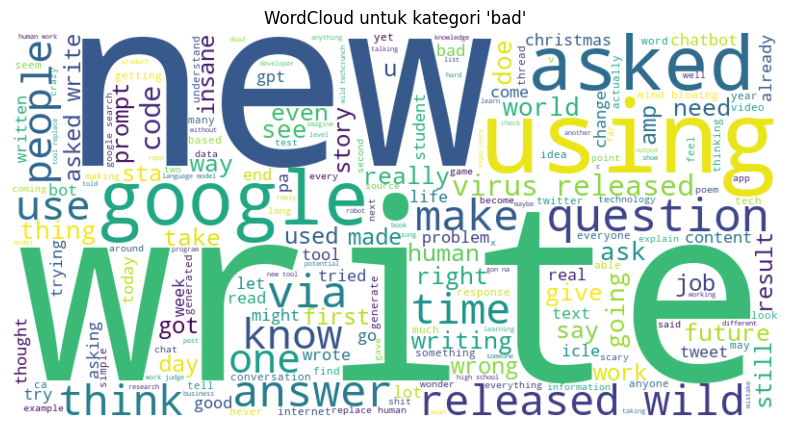

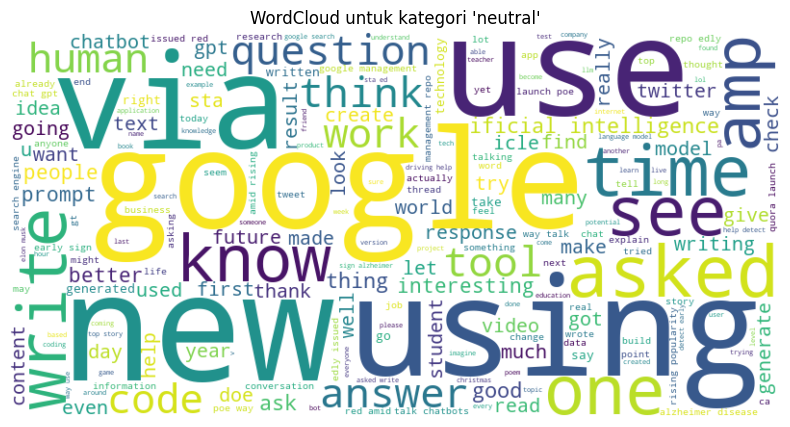

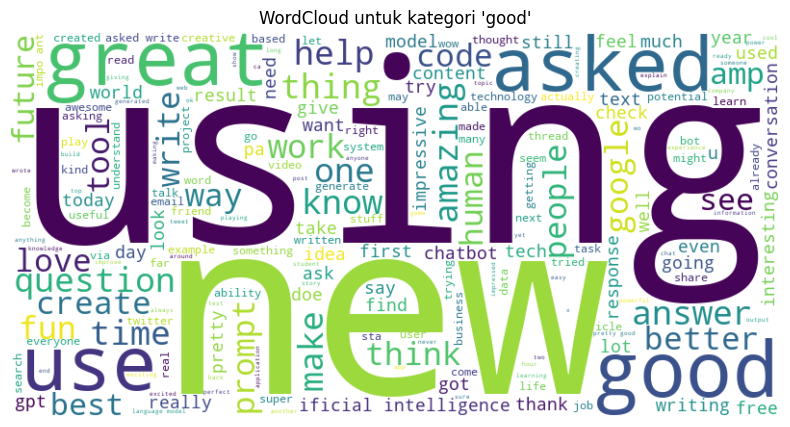

In [17]:
# Fungsi untuk membuat WordCloud
def generate_wordcloud(text, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud untuk kategori '{category}'")
    plt.axis('off')
    plt.show()

# Ambil data untuk masing-masing kategori
bad_tweets = df_word[df_word['labels'] == 'bad']['tweets_prosesed'].tolist()
neutral_tweets = df_word[df_word['labels'] == 'neutral']['tweets_prosesed'].tolist()
good_tweets = df_word[df_word['labels'] == 'good']['tweets_prosesed'].tolist()

# Gabungkan teks masing-masing kategori
bad_text = ' '.join(bad_tweets)
neutral_text = ' '.join(neutral_tweets)
good_text = ' '.join(good_tweets)

# Membuat WordCloud untuk masing-masing kategori
generate_wordcloud(bad_text, "bad")
generate_wordcloud(neutral_text, "neutral")
generate_wordcloud(good_text, "good")

Setelah dilakukan text prepocessing bahwa kata pada kategori bad didominasi oleh write, new, dan google. Pada kategori netral didominasi oleh new, google, dan time. Sedangkan pada kategori good didominasi oleh great dan good.

In [18]:
# Mengubah target dari string ke numeric
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['labels'])
df

,tweets,labels,tweets_prosesed,class
0,So this #ChatGPT thing is kinda scary. It shou...,bad,thing kinda scary able,0
1,I fed #chatgpt our funding memo and asked it t...,bad,fed funding memo asked write common question a...,0
2,ChatGPT is mind blowing 🥶!!,bad,mind blowing,0
3,at first i was a little spooked by the new cha...,bad,first little spooked new thing watched multipl...,0
4,Trying ChatGPT!!! https://t.co/FVYpXo8aXE,bad,trying,0
...,...,...,...,...
11995,What if ChatGPT is pulling a theranos on us an...,good,pulling theranos u southeast asian honor stude...,1
11996,#MidJourney #OpenAi #GPT #StableDiffusion2 #Da...,good,join want whole lot idea sta prompt collage wo...,1
11997,"Is #ChatGPT correct, ""any object that exists w...",good,correct object exists within given space must ...,1
11998,"#chatGPT isn't hype, it's harbinger. These cha...",good,hype harbinger change coming whether tech pund...,1


In [19]:
# Get Label Name
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'bad': 0, 'good': 1, 'neutral': 2}


In [20]:
# Split antara X dan y

X = df['tweets_prosesed'].to_numpy() # features
y = df['class'].to_numpy() # target


In [21]:
# Split between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=10)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (7680,)
Val Size :  (1920,)
Test Size :  (2400,)


In [22]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<7680x10779 sparse matrix of type '<class 'numpy.int64'>'
	with 78392 stored elements in Compressed Sparse Row format>

In [23]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu Document

jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  10779
Panjang maksimum kalimat :  38 kata


In [24]:
# Mengubah Target ke dalam One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [25]:
# Tensorflow pipeline
train_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe)).batch(20)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe)).batch(20)

In [26]:

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

In [27]:
# Embedding Layer

embedding_baseline = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [28]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'like',
 'new',
 'google',
 'write',
 'use',
 'asked',
 'using',
 'question',
 'time',
 'good',
 'answer',
 'make',
 'get',
 'know',
 'human',
 'see',
 'tool',
 'code']

# 8 - Model

In [29]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [30]:

model_imp1 = Sequential()

# Layer Text Vectorization
model_imp1.add(text_vectorization)

# Layer Embedding
model_imp1.add(embedding_baseline)

# Hidden Layer 1
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Hidden Layer 2
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Layer Output
model_imp1.add(Dense(3, activation='softmax'))

# Compile
model_imp1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_imp1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 38)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 38, 128)           1379712   
                                                                 
 bidirectional (Bidirectiona  (None, 38, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

- Berdasarkan device yang saya gunakan bahwa total data 12.000 dalam deep learning saya menganggap ini adalah data cukup besar sehingga saya memilih algoritma LSTM.
- Pemilihan metrix akurasi didasarkan karena saya sudah menyeimbangkan masing masing kelas dengan random undersampling sehingga tidak masalah ketika menggunakan metrix akurasi.
- Pemilihan optimizer adam karena mempercepat proses pembelajaran dan konvergensi model.
- Pemilihan tf.keras.layers.Bidirectional dalam arsitektur model bertujuan untuk meningkatkan kemampuan model dalam memahami konteks teks dalam dua arah, yaitu maju (forward) dan mundur (backward).

In [31]:
# Mendefinisikan EarlyStopping
#early_stopping = EarlyStopping(monitor='accuracy', patience=7, restore_best_weights=True)

model_imp1_hist = model_imp1.fit(train_pipe, epochs=20, batch_size=20, validation_data=val_pipe)

Epoch 1/20


384/384 [==============================] - 41s 89ms/step - loss: 0.7724 - accuracy: 0.6529 - val_loss: 0.6182 - val_accuracy: 0.7443
Epoch 2/20
384/384 [==============================] - 31s 80ms/step - loss: 0.3681 - accuracy: 0.8626 - val_loss: 0.6837 - val_accuracy: 0.7229
Epoch 3/20
384/384 [==============================] - 32s 83ms/step - loss: 0.1871 - accuracy: 0.9353 - val_loss: 0.9631 - val_accuracy: 0.7073
Epoch 4/20
384/384 [==============================] - 32s 82ms/step - loss: 0.1098 - accuracy: 0.9646 - val_loss: 1.1026 - val_accuracy: 0.6964
Epoch 5/20
384/384 [==============================] - 31s 81ms/step - loss: 0.0794 - accuracy: 0.9741 - val_loss: 1.2378 - val_accuracy: 0.7047
Epoch 6/20
384/384 [==============================] - 32s 83ms/step - loss: 0.0478 - accuracy: 0.9857 - val_loss: 1.3218 - val_accuracy: 0.7234
Epoch 7/20
384/384 [==============================] - 32s 84ms/step - loss: 0.0337 - accuracy: 0.9896 - val_loss: 1.5776 - val_accuracy: 0.6948
Epo

In [32]:
# Create DataFrame

history_imp1_df = pd.DataFrame(model_imp1_hist.history)
history_imp1_df

,loss,accuracy,val_loss,val_accuracy
0,0.772422,0.652865,0.618201,0.744271
1,0.368066,0.862630,0.683679,0.722917
2,0.187067,0.935286,0.963127,0.707292
3,0.109849,0.964583,1.102606,0.696354
4,0.079432,0.974089,1.237849,0.704687
5,0.047773,0.985677,1.321817,0.723437
6,0.033721,0.989583,1.577637,0.694792
7,0.031049,0.991276,1.586788,0.696354
8,0.026074,0.992057,1.646722,0.697396
9,0.021781,0.993359,1.631376,0.717188


<Axes: >

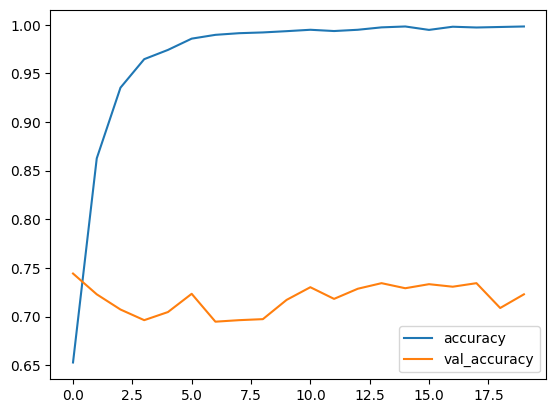

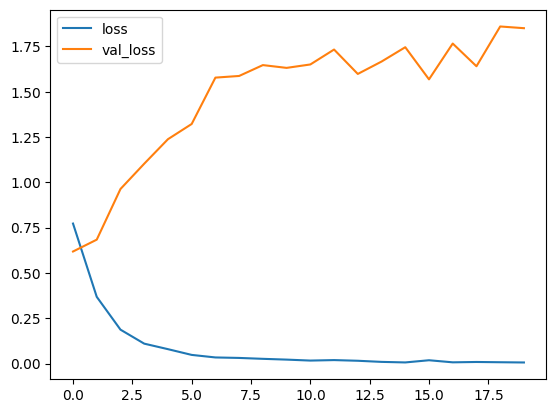

In [33]:
# Plot

history_imp1_df[['accuracy', 'val_accuracy']].plot()
history_imp1_df[['loss', 'val_loss']].plot()

In [34]:
y_pred_improve = model_imp1.predict(X_test)
y_pred_improve = np.argmax(y_pred_improve, axis=1)

print(classification_report(y_test, y_pred_improve))

75/75 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       818
           1       0.77      0.74      0.75       778
           2       0.63      0.70      0.67       804

    accuracy                           0.74      2400
   macro avg       0.75      0.74      0.74      2400
weighted avg       0.75      0.74      0.74      2400



In [35]:
# Pembuatan DF Act vs Pred
act_pred_imp1 = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_improve)
})
df_act_pred_imp1 = pd.concat([pd.DataFrame(X_test), act_pred_imp1],axis=1)
df_act_pred_imp1 

,0,actual,prediction
0,new post google working protect search,2,2
1,well break turing test need new test doe somet...,1,1
2,know future bring know hedging bet,0,0
3,owned cofounded elon musk recently using twitt...,2,2
4,please reboot rebooot,2,0
...,...,...,...
2395,scenario created quite well written even givin...,1,1
2396,one best thing ever made,1,1
2397,want complete story getting long long guess go...,2,0
2398,bloomberg law creator bolster legal rank issue...,2,2


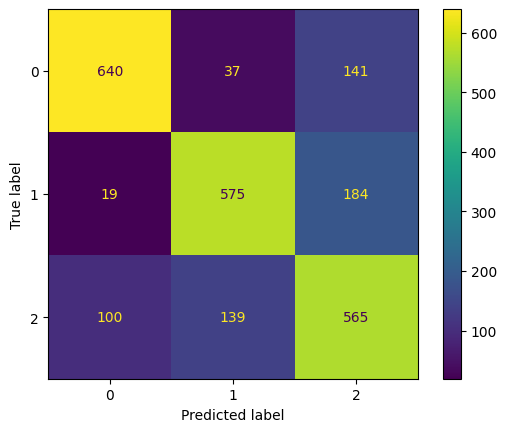

In [36]:
# Confusion Matrix
cm_test_imp1 = confusion_matrix(y_test, y_pred_improve)
ConfusionMatrixDisplay(cm_test_imp1).plot()

# 8 - Improve model


In [37]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [38]:

model_baseline = Sequential()

# Layer Text Vectorization
model_baseline.add(text_vectorization)

# Layer Embedding
model_baseline.add(embedding_baseline)

# Hidden Layer 1
model_baseline.add(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Hidden Layer 2
model_baseline.add(LSTM(64, kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Layer Output
model_baseline.add(Dense(3, activation='softmax'))

# Compile
model_baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
model_baseline.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 38)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 38, 128)           1379712   
                                                                 
 lstm (LSTM)                 (None, 38, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1,560,899
Trainable params: 1,560,899
Non-trainable params: 0
______________________________________________

Dalam proses improve model saya mencoba menggunakan basemodel tanpa menggunakan tf.keras.layers.Bidirectional dalam arsitektur model bertujuan untuk mempercepat proses.

In [39]:
# Train the Model
model_baseline_hist = model_baseline.fit(train_pipe, epochs=20, batch_size=20, validation_data=val_pipe)

Epoch 1/20


384/384 [==============================] - 30s 68ms/step - loss: 0.2758 - accuracy: 0.9005 - val_loss: 1.0987 - val_accuracy: 0.7063
Epoch 2/20
384/384 [==============================] - 25s 66ms/step - loss: 0.0970 - accuracy: 0.9738 - val_loss: 1.2823 - val_accuracy: 0.6964
Epoch 3/20
384/384 [==============================] - 25s 66ms/step - loss: 0.0778 - accuracy: 0.9806 - val_loss: 1.3720 - val_accuracy: 0.6854
Epoch 4/20
384/384 [==============================] - 26s 68ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 1.3929 - val_accuracy: 0.7151
Epoch 5/20
384/384 [==============================] - 27s 69ms/step - loss: 0.0510 - accuracy: 0.9868 - val_loss: 1.4341 - val_accuracy: 0.7141
Epoch 6/20
384/384 [==============================] - 27s 71ms/step - loss: 0.0444 - accuracy: 0.9880 - val_loss: 1.5245 - val_accuracy: 0.7047
Epoch 7/20
384/384 [==============================] - 23s 60ms/step - loss: 0.0479 - accuracy: 0.9871 - val_loss: 1.2881 - val_accuracy: 0.6984
Epo

In [40]:
history_baseline_df = pd.DataFrame(model_baseline_hist.history)
history_baseline_df

,loss,accuracy,val_loss,val_accuracy
0,0.275763,0.900521,1.098675,0.706250
1,0.096963,0.973828,1.282291,0.696354
2,0.077822,0.980599,1.371997,0.685417
3,0.055471,0.984375,1.392908,0.715104
4,0.051029,0.986849,1.434119,0.714063
5,0.044392,0.988021,1.524508,0.704687
6,0.047904,0.987109,1.288105,0.698438
7,0.025228,0.994271,1.510142,0.726042
8,0.038111,0.989844,1.482603,0.703646
9,0.027978,0.992057,1.423831,0.727604


<Axes: >

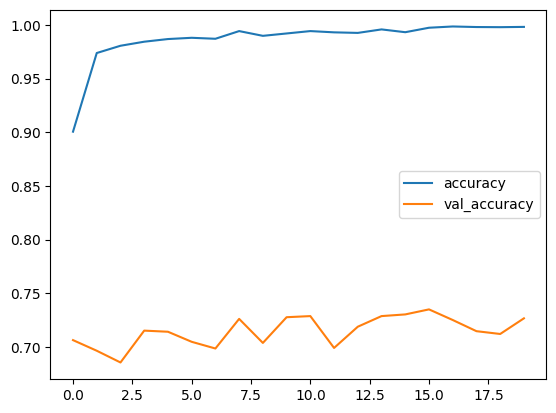

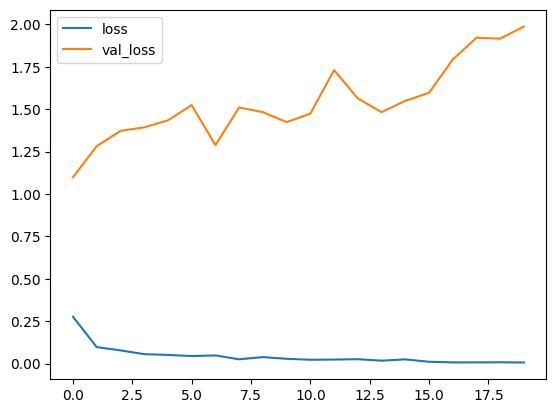

In [41]:
# Plot

history_baseline_df[['accuracy', 'val_accuracy']].plot()
history_baseline_df[['loss', 'val_loss']].plot()

In [42]:
# Model evaluation test set

y_pred_baseline = model_baseline.predict(X_test)
y_pred_baseline = np.argmax(y_pred_baseline, axis=1)

print(classification_report(y_test, y_pred_baseline))

75/75 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       818
           1       0.74      0.75      0.75       778
           2       0.61      0.71      0.66       804

    accuracy                           0.73      2400
   macro avg       0.74      0.73      0.73      2400
weighted avg       0.74      0.73      0.73      2400



In [43]:
# Pembuatan DF Act vs Pred
act_pred_baseline = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_baseline)
})
df_act_pred_baseline = pd.concat([pd.DataFrame(X_test), act_pred_baseline],axis=1)
df_act_pred_baseline 

,0,actual,prediction
0,new post google working protect search,2,2
1,well break turing test need new test doe somet...,1,1
2,know future bring know hedging bet,0,0
3,owned cofounded elon musk recently using twitt...,2,2
4,please reboot rebooot,2,0
...,...,...,...
2395,scenario created quite well written even givin...,1,1
2396,one best thing ever made,1,1
2397,want complete story getting long long guess go...,2,0
2398,bloomberg law creator bolster legal rank issue...,2,2


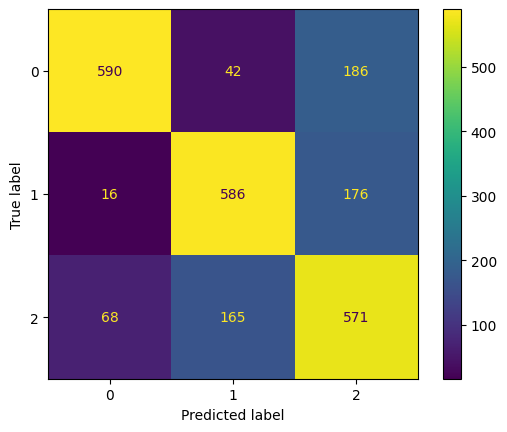

In [44]:
# Confusion Matrix
cm_test_baseline = confusion_matrix(y_test, y_pred_baseline)
ConfusionMatrixDisplay(cm_test_baseline).plot()

- Sebelum Improve:

    Waktu train diatas 30 detik



- Setelah Improve:

    Waktu train dibawah 30 detik
    

Dari hasil di atas, terlihat bahwa model yang telah diimprovisasi (setelah improve) memiliki durasi train yang lebih cepat dibandingkan dengan model yang belum di improve walaupun tidak terlalu berpengaruh perubahan pada akurasi hasil test set. Sehingga saya memutuskan untuk menggunakan model yang telah diimprove (model_baseline) untuk disave.

Berdasarkan hasil train dan test, kedua model mengalami overfitting.

# Cek kesalahan prediksi


In [70]:
df_act_pred_baseline

,0,actual,prediction
0,new post google working protect search,2,2
1,well break turing test need new test doe somet...,1,1
2,know future bring know hedging bet,0,0
3,owned cofounded elon musk recently using twitt...,2,2
4,please reboot rebooot,2,0
...,...,...,...
2395,scenario created quite well written even givin...,1,1
2396,one best thing ever made,1,1
2397,want complete story getting long long guess go...,2,0
2398,bloomberg law creator bolster legal rank issue...,2,2


In [76]:
# Memisahkan kelas
class_0 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 0]
class_1 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 1]
class_2 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 2]

# Menghitung frekuensi kata
def get_word_counts(df_act_pred_baseline):
    word_counts = Counter()
    for index, row in df_act_pred_baseline.iterrows():
        words = row.drop(['actual', 'prediction']).str.split()
        word_counts.update(words[0])
    return word_counts

# filter top kata untuk suatu kelas (FP atau FN)
def top_k_words(df_act_pred_baseline, k, target_col):
    df_act_pred_baseline = df_act_pred_baseline[df_act_pred_baseline['prediction'] == target_col]
    word_counts = get_word_counts(df_act_pred_baseline)
    top_k_words = [word for word, _ in word_counts.most_common(k)]
    return top_k_words

# Kelas 0 False Positif 
class_0_fp = top_k_words(class_0, 10, 1)

# Kelas 0 False Negatif 
class_0_fn = top_k_words(class_0, 10, 2)

# Kelas 1 False Positif 
class_1_fp = top_k_words(class_1, 10, 0)

# Kelas 1 False Negatif 
class_1_fn = top_k_words(class_1, 10, 2)

# Kelas 2 False Positif 
class_2_fp = top_k_words(class_2, 10, 0)

# Kelas 2 False Negatif 
class_2_fn = top_k_words(class_2, 10, 1)

# Mencetak hasil
print("False Positif Kelas bad :", class_0_fp)
print("False Negatif Kelas bad :", class_0_fn)
print("False Positif Kelas good :", class_1_fp)
print("False Negatif Kelas good :", class_1_fn)
print("False Positif Kelas neutral :", class_2_fp)
print("False Negatif Kelas neutral :", class_2_fn)

False Positif Kelas bad : ['go', 'people', 'time', 'look', 'write', 'work', 'year', 'already', 'ask', 'story']
False Negatif Kelas bad : ['asked', 'make', 'google', 'amp', 'write', 'use', 'get', 'question', 'first', 'day']
False Positif Kelas good : ['would', 'time', 'people', 'engineering', 'tweet', 'give', 'much', 'humanity', 'get', 'see']
False Negatif Kelas good : ['like', 'time', 'asked', 'good', 'get', 'write', 'human', 'language', 'create', 'using']
False Positif Kelas neutral : ['answer', 'write', 'using', 'story', 'elon', 'musk', 'good', 'think', 'content', 'asked']
False Negatif Kelas neutral : ['like', 'new', 'use', 'year', 'write', 'model', 'one', 'asked', 'good', 'time']


Kelas bad:

- False Positif: tweet dengan kata kunci go, people, time, look, write, work, year, already, ask, dan story cenderung salah diklasifikasikan sebagai kelas bad.
- False Negatif: tweet yang mengandung kata kunci asked, make, google, amp, write, use, get, question, first, dan day cenderung salah diklasifikasikan sebagai kelas bad.

Kelas good:

- False Positif: tweet yang mengandung kata kunci would, time, people, engineering, tweet, give, much, humanity, get, dan see cenderung salah diklasifikasikan sebagai kelas good.
- False Negatif: tweet dengan kata kunci like, time, asked, good, get, write, human, language, create, dan using cenderung salah diklasifikasikan sebagai kelas good.

Kelas netral:

- False Positif: tweet dengan kata kunci answer, write, using, story, elon, musk, good, think, content, dan asked cenderung salah diklasifikasikan sebagai kelas neutral.
- False Negatif: tweet yang mengandung kata kunci like, new, use, year, write, model, one, asked, good, dan time cenderung salah diklasifikasikan sebagai kelas neutral.

# 9 - Saving

In [50]:
# Save the model with save_format='tf'
model_baseline.save('best_model', save_format='tf')

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


In [51]:
# Save Model
model_baseline.save('best_model1')

INFO:tensorflow:Assets written to: best_model1\assets


INFO:tensorflow:Assets written to: best_model1\assets


# 10 - Kesimpulan

`Berdasarkan proses dan analisis yang telah dilakukan pada data di atas, berikut adalah kesimpulan secara keseluruhan:`

- Ukuran Data: Data terdiri dari 219.294 baris dan 2 kolom. Data ini tidak memiliki missing values.

- Handling Data Terduplikasi: Data yang terduplikasi telah dihapus untuk menghindari pengaruh data yang berlebihan pada model.

- Handling Data Imbalance: Data imbalance telah diatasi dengan menggunakan teknik random undersampling untuk setiap kelas sehingga setiap kelas memiliki 4.000 data.

- Visualisasi WordCloud: WordCloud digunakan untuk memvisualisasikan kata-kata yang sering muncul dalam teks tweet sebelum dilakukan text preprocessing. Kata-kata yang sering muncul ditampilkan dengan ukuran teks yang lebih besar.

- Text Preprocessing: Teks tweet telah di preprocessing dengan mengubah teks menjadi lowercase, menghilangkan mention, hashtag, link, karakter khusus, dan kata "RT". Selain itu, dilakukan tokenisasi dan lemmatisasi untuk mengubah kata-kata menjadi bentuk dasar.

- Model Selection: Berdasarkan karakteristik data yang besar dan kompleks, serta tujuan analisis sentimen, digunakan model LSTM untuk meningkatkan kemampuan model dalam memahami konteks teks.

- Model Evaluation: Model dievaluasi menggunakan metrik akurasi karena data telah di seimbangkan melalui random undersampling sehingga akurasi dapat memberikan gambaran yang baik tentang performa model.

- Overfitting: Terdapat masalah overfitting pada model, yaitu model memiliki akurasi yang tinggi pada data latih (train accuracy) tetapi performa menurun pada data uji (test accuracy). Hal ini menunjukkan model memiliki kemampuan untuk mengingat data latih dengan baik tetapi tidak mampu melakukan generalisasi dengan baik pada data test.

- Improvement Model: Dilakukan percobaan untuk memperbaiki masalah overfitting dengan mengubah arsitektur model, namun tetap menghadapi masalah overfitting meskipun durasi train lebih cepat.

- Kesimpulan: Dengan mempertimbangkan kondisi train dan hasil akurasi pada data uji, model ini dapat digolongkan sebagai "overfitting". Terdapat perbedaan yang cukup besar antara train accuracy dan test accuracy, yang menunjukkan bahwa model tidak mampu melakukan generalisasi dengan baik pada data uji.

`Rekomendasi untuk perbaikan selanjutnya adalah:`

- Melakukan penyesuaian arsitektur model untuk mengurangi overfitting, seperti menggunakan teknik  dropout
- Memperluas kamus stop_words untuk menghapus lebih banyak kata-kata yang tidak relevan dalam analisis sentimen.


`Kelebihan:`

- High Train Accuracy: Hasil train accuracy yang tinggi (0.9) menunjukkan bahwa model memiliki kemampuan untuk "menghafal" data latih dengan baik dan dapat mengklasifikasikan data latih dengan akurat.

- Cepat dalam Proses Training: Setelah dilakukan perbaikan (improve model) dengan menghapus lapisan Bidirectional, durasi waktu training menjadi lebih cepat dibandingkan dengan model sebelumnya.

`Kekurangan:`

- Penurunan Test Accuracy setelah Improvement: Meskipun telah dilakukan perbaikan (improve model) dengan menghapus lapisan Bidirectional, test accuracy mengalami penurunan (0.69), yang menandakan bahwa model ini masih mengalami masalah overfitting.

- Overfitting: Perbedaan yang signifikan antara train accuracy dan test accuracy menunjukkan adanya masalah overfitting. Model "terlalu menghafal" data latih dan tidak dapat secara efektif menangkap pola yang relevan pada data uji.

- Ketidakakuratan Prediksi: Model yang overfitting cenderung memberikan prediksi yang tidak akurat pada data baru atau data uji. Hal ini dapat menyebabkan keputusan bisnis yang salah, misalnya prediksi sentimen yang tidak tepat pada produk atau layanan tertentu.

- Kehilangan Kesempatan: Overfitting dapat menyebabkan kehilangan kesempatan bisnis. Jika model tidak dapat mengenali pola yang relevan dalam data uji, maka kesempatan untuk mengambil keputusan bisnis yang lebih tepat dan optimal dapat terlewatkan.

- Efisiensi Rendah: Model yang kompleks akibat overfitting dapat memerlukan lebih banyak sumber daya komputasi dan waktu untuk pelatihan dan prediksi. Hal ini dapat menghambat efisiensi dan kinerja proses bisnis.

`Implementasi pada bisnis:`
- Feedback Pelanggan yang Lebih Cepat dan Akurat: Implementasi model sentimen analisis dalam bisnis memungkinkan perusahaan untuk secara cepat dan akurat menganalisis feedback pelanggan dari berbagai sumber seperti ulasan produk, media sosial, atau survei. Hal ini membantu dalam memahami perasaan dan preferensi pelanggan dengan lebih baik, sehingga perusahaan dapat merespons secara tepat waktu dan melakukan perbaikan atau penyesuaian produk dan layanan sesuai kebutuhan pelanggan.

- Pengambilan Keputusan Berdasarkan Data: Model sentimen analisis membantu perusahaan dalam mengambil keputusan berdasarkan data dan bukti nyata dari sentimen pelanggan. Dengan analisis data yang akurat, perusahaan dapat mengidentifikasi pola dan tren yang relevan untuk menginformasikan keputusan bisnis strategis, seperti pengembangan produk baru, peningkatan layanan pelanggan, atau perbaikan proses operasional.

- Meningkatkan Kepuasan Pelanggan dan Loyalitas: Dengan memahami sentimen pelanggan, perusahaan dapat meningkatkan kualitas produk dan layanan sesuai dengan harapan pelanggan. Ini berdampak positif pada kepuasan pelanggan dan meningkatkan loyalitas pelanggan. Pelanggan yang puas cenderung menjadi pelanggan yang loyal dan berpotensi menjadi pembawa pesan positif tentang merek atau perusahaan, yang berkontribusi pada pertumbuhan dan kesuksesan jangka panjang bisnis.